In [1]:
import pandas as pd
import numpy as np
import numpy  as np
from nltk.corpus import stopwords,wordnet
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition
import time
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
import warnings
%matplotlib inline
from sklearn.cluster import KMeans  
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Reading Data & Data Overview

In [103]:
data = pd.read_csv('/Users/leshensui/Documents/train_data.csv', header=0, sep=',',
                parse_dates=['date', 'release_date', 'update_date'],
                infer_datetime_format=True, encoding = 'latin1')

In [104]:
data.columns

Index(['asin', 'date', 'downvotes', 'review_comments', 'review_id',
       'review_text', 'review_type', 'reviewer', 'star_rating', 'upvotes',
       'categories', 'description', 'developer', 'in_app_purchase',
       'mas_rating', 'min_os_version', 'num_permissions', 'num_screenshots',
       'price', 'release_date', 'size_MB', 'title', 'update_date'],
      dtype='object')

In [105]:
useful_data = data[['asin','date','categories', 'description','review_text','reviewer','star_rating','price','developer']]
useful_data.head()

,asin,date,categories,description,review_text,reviewer,star_rating,price,developer
0,B00OPRXVIC,2014-11-06,Novelty,THIS APP HAS EXPIRED. PLEASE DO NOT BUY.Hey pa...,this is cool. parents can write an email from ...,A2NGN1TFABVU8Q,5,199.0,AppsByMichael
1,B008JQPY2G,2012-07-21,"Kids,Games",Attention Monsters Fans... Now you can Get the...,its no good I didnt like it at all,A3SHL50ZU1K96M,1,99.0,SMGC Publishing
2,B008JQPY2G,2013-01-04,"Kids,Games",Attention Monsters Fans... Now you can Get the...,absolutely terrible. I mean that I did not lik...,A9MOKV997YYIN,1,99.0,SMGC Publishing
3,B008JQPY2G,2015-10-16,"Kids,Games",Attention Monsters Fans... Now you can Get the...,Fun game,A3VYN5P1IRUL3H,5,99.0,SMGC Publishing
4,B008JQPY2G,2013-03-05,"Kids,Games",Attention Monsters Fans... Now you can Get the...,"This game downloaded for me, but when I try to...",AIX9ODIJLREIM,1,99.0,SMGC Publishing


### Groupby user and item, then plot the purchase distribution

In [106]:
item_list = useful_data.groupby('asin').groups.keys()
reviewer_list = useful_data.groupby('reviewer').groups.keys()

In [107]:
reviewer = useful_data.groupby('reviewer').groups
d = {}
for k in reviewer:
    key = len(reviewer[k])
    if key in d:
        d[key] += 1
    else:
        d[key] = 1

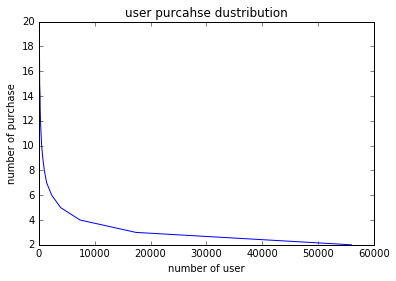

In [108]:
import matplotlib.pylab as plt

lists = sorted(d.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.xlabel('number of user')
plt.ylabel('number of purchase')
plt.title('user purcahse dustribution')
plt.plot(y[1:20], x[1:20])
plt.show()

### Removing inactive users and items

In [ ]:
groups = data[['asin', 'description', 'star_rating']].groupby(['asin','description'])
temp = groups.count()
temp = temp[temp['star_rating']>10]
temp = temp.rename(columns = {'star_rating': 'count'})
df_mean = groups.mean()
df_mean = df_mean.rename(columns = {'star_rating': 'mean_star'})
df = df_mean.merge(temp, left_index = True, right_index = True)['mean_star'].to_frame()
df_description = pd.DataFrame(df.index.values.tolist(), columns = ['asin', 'description'])

In [6]:
groups2 = useful_data[['asin', 'reviewer', 'star_rating']].groupby(['reviewer'])
temp = groups2.count()
temp = temp[temp['star_rating']>1]

In [109]:
reviewers = temp.index.tolist()
items = df_description['asin'].values.tolist()
data = data.loc[data['reviewer'].isin(reviewers)]
data = data.loc[data['asin'].isin(items)]
data.head()

,asin,date,downvotes,review_comments,review_id,review_text,review_type,reviewer,star_rating,upvotes,...,in_app_purchase,mas_rating,min_os_version,num_permissions,num_screenshots,price,release_date,size_MB,title,update_date
9,B004VMVFIY,2011-11-19,NaN,0,R11AANFJC6VN4U,A friend raved about this app on her IPhone. ...,Verified Purchase,A1BNJNEN9MWVJ3,1,NaN,...,0,All Ages,2.2,12,6,299.0,2011-04-07,1.6,Grocery Gadget - Shopping List,2013-03-22
15,B004VMVFIY,2015-04-22,NaN,0,R25AO36F9E8MNJ,Rev. Review: 5/23/15 Org. Review: 4/22/2015 ...,Verified Purchase,A9S9RXZFJ0WF,4,NaN,...,0,All Ages,2.2,12,6,299.0,2011-04-07,1.6,Grocery Gadget - Shopping List,2013-03-22
18,B004VMVFIY,2013-06-03,NaN,0,R2HH4E0PZD3370,All of my roommates have it on their devices. ...,Verified Purchase,A1GU4E3UXPNRPM,4,NaN,...,0,All Ages,2.2,12,6,299.0,2011-04-07,1.6,Grocery Gadget - Shopping List,2013-03-22
20,B004VMVFIY,2014-05-09,NaN,0,R2SUI0FFFGXJN0,I have been using Grocery Gadget on the web an...,Verified Purchase,A2WMLNOZXLRTL4,1,NaN,...,0,All Ages,2.2,12,6,299.0,2011-04-07,1.6,Grocery Gadget - Shopping List,2013-03-22
21,B004VMVFIY,2016-03-30,NaN,0,R2T199EB4XPBZL,Extremely disapointed had used program with sa...,Verified Purchase,A2NOCDANIYGTEN,1,NaN,...,0,All Ages,2.2,12,6,299.0,2011-04-07,1.6,Grocery Gadget - Shopping List,2013-03-22


### NLP

In [21]:
#stopwords = nltk.corpus.stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def genCorpus(theText):
    #set dictionaries
    stopwords = nltk.corpus.stopwords.words('english')
    theStemmer = nltk.stem.porter.PorterStemmer() #Martin Porters celebrated stemming algorithm    
    #pre-processing
    theText = theText.split()
    tokens = [token.lower() for token in theText] #ensure everything is lower case
    tokens = [re.sub(r'[^a-zA-Z0-9]+', ' ',token) for token in tokens] #remove special characters but leave word in tact
    tokens = [token for token in tokens if token.lower().isalpha()] #ensure everything is a letter
    tokens = [word for word in tokens if word not in stopwords] #rid of stop words
    tokens = [theStemmer.stem(word) for word in tokens] #stem words uing porter stemming algorithm
    tokens = " ".join(tokens) #need to pass string seperated by spaces       
    return tokens

def clean(text): #define function to clean the data set
    stopwords = nltk.corpus.stopwords.words('english')
    #theStemmer = nltk.stem.porter.PorterStemmer()
    #wordnet_lemmatizer = WordNetLemmatizer()
    theText = text.split()
    words = [word.lower() for word in theText]
    tokens = [word for word in words if word not in stopwords]
    #tokens = [wordnet_lemmatizer.lemmatize(word) for word in words]
    tokens = [re.sub(r'[^a-zA-Z]+', ' ',token) for token in tokens]
    #tokens = " ".join(tokens)
    return tokens

def pos_select(input_list):
    total_pos = []
    for i in input_list:
        total_pos.append(nltk.pos_tag(i, tagset = 'universal'))
    total_words = []
    for word in total_pos:
        lis = []
        for i in word:
            if str(i[1]) == 'NOUN':
                if len(str(i[0])) > 2:
                    lis.append(str(i[0]))
        total_words.append(lis)
    words = []
    for word in total_words:
        words2 = ' '.join(word)
        words.append(words2)
    return words

In [110]:
df_description['mean_star'] = df['mean_star'].values
text = df_description['description']
ls = text.values.tolist()
ls2 = []
for i in ls:
    ls2.append(clean(i))
words = pos_select(ls2)
words[0]

'apple selection itunes  app store essentials  selling iphone app years my kids app   by father  under yrs   perfect  fun toddler  toddler buy yet   by ro dub  mama doctor doctor said   no monkeys parents children children monkeys counting game rhyme everybody counting  children math skills color recognition monkeys monkey  objects concepts stop go  on off  alarm clock rings  lamp  telephone  family portrait touch  reading  words fosters word recognition sentence building skills  step learning  singing  music types to  country  rock  pop sing a long  explore  touch  control game options freedom preschooler  application bed  children year pre toddler preschool features touch  peekaboo dog  button stops monkeys children bedroom   shake  monkeys somersaults  press number monkeys watch drop interact objects apps children  macdonald contact questions  you thanks loeschware llc'

### Feature extraction & PCA

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=2000,
                                 min_df=2, stop_words='english',
                                 use_idf=True, ngram_range=(1,1))
tfidf_matrix = tfidf_vectorizer.fit_transform(words)
terms = tfidf_vectorizer.get_feature_names()

In [89]:
dtm = pd.DataFrame(tfidf_matrix.toarray())
dtm.columns = tfidf_vectorizer.get_feature_names()

In [92]:
dtm_dense = tfidf_matrix.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
np.sum(centered_dtm,axis=0)[:,:10]

matrix([[  2.21526356e-14,  -1.30108598e-14,  -1.34391196e-13,
           1.18453858e-13,   1.71212870e-14,   1.16845769e-13,
           2.50828872e-13,  -7.46017831e-14,  -1.44120826e-13,
          -1.12415719e-13]])

In [93]:
u,s,vt = np.linalg.svd(centered_dtm)

### Find the best low effective rank

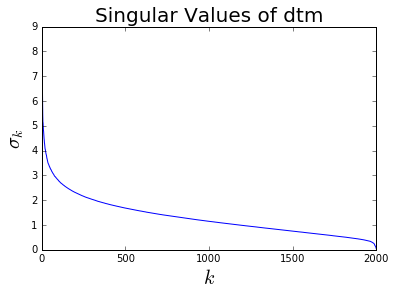

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(s)+1),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
_ = plt.title(r'Singular Values of dtm',size=20)

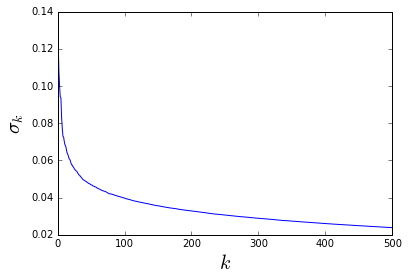

In [96]:
fig = plt.figure(figsize=(6,4))
Anorm = np.linalg.norm(dtm_dense)
plt.plot(range(1,501),s[0:500]/Anorm)
plt.xlim([0,500])
plt.xlabel(r'$k$',size=20)
_ = plt.ylabel(r'$\sigma_k$',size=20)

In [38]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(100, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
df_feature = pd.DataFrame(dtm_lsa)

### Parameter tunning & Cluster 

In [ ]:
def get_cluster(cluster, df): 
    d = {}
    i = 0
    cluster = cluster.tolist()
    while i < len(cluster):
        d.setdefault(cluster[i],[]).append(pd.DataFrame([df_feature.loc[i,]]).index.values[0])
        i = i+1
    return d
from sklearn.cluster import KMeans  
import sklearn.metrics as metrics
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()

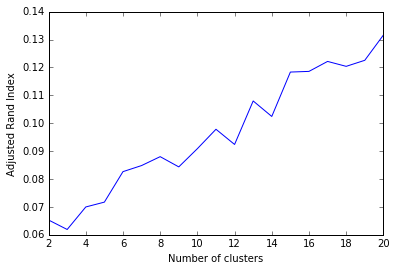

In [82]:
sc_evaluate_clusters(df_feature, 20)

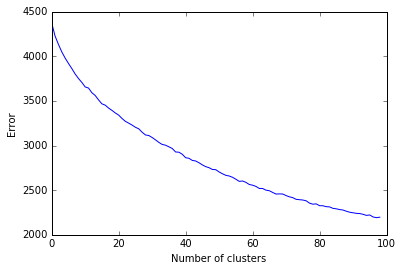

In [84]:
error = []
for k in range(1,100):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(df_feature)
    error.append(kmeans.inertia_)
plt.plot(range(len(error)),error[0:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')
plt.show()

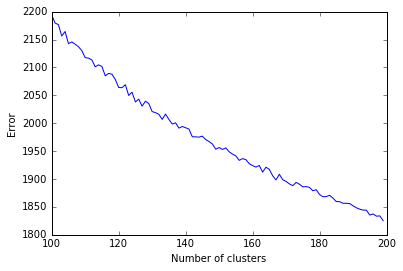

In [91]:
plt.plot(range(100,100+len(error2)),error2[0:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')
plt.show()

In [118]:
k=100
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=1)
kmeans_cluster = kmeans.fit_predict(df_feature)
kmeans_predict = kmeans.predict(df_feature)
kmeans_cluster

array([41, 39, 27, ..., 72,  8,  5], dtype=int32)

In [119]:
def get_cluster(cluster, df): 
    d = {}
    i = 0
    cluster = cluster.tolist()
    while i < len(cluster):
        d.setdefault(cluster[i],[]).append(pd.DataFrame([df_feature.loc[i,]]).index.values[0])
        i = i+1
    return d
kcluster = get_cluster(kmeans_cluster, df_feature)

### Look at the topics & Plot cluster sizes

In [117]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
no_topics = 100

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=10, \
                                learning_method='online', learning_offset=50., \
                                random_state=0).fit(dtm)

nmf = NMF(n_components=no_topics, random_state=1, \
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(dtm)

def display_topics(model, feature_names, no_top_words):
    k = 0
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        k += 1
        if k > 5:
            break
no_top_words = 20
       
#display_topics(lda, terms, no_top_words)
display_topics(nmf, terms, no_top_words)

Topic 0:
game play games graphics players gameplay try features modes style help score master goal achievements strategy way hours rules awards
Topic 1:
mode modes challenge object ways difficulty picture bonus step play child practice accept hidden timed rounds presents zen multiplayer experience
Topic 2:
games fish bigfishgames bigfi pc sh mac discover adventure facebook http bigfishtwitter bigfishgamesmobile marketplace big www amazon selection type enjoy
Topic 3:
items hints challenge item list timed silhouettes bonus accept modes ways random rounds experience selection picture training hiding beginners scenes
Topic 4:
word words search language letters dictionary list game games categories crossword grid scores association sight phrases level modes dictionaries vocabulary
Topic 5:
piece jigsaw puzzleboss pieces puzzles facebook support puzzlebossgames captivate photographers photography families drawn profiles sizes minute session adults resolution required


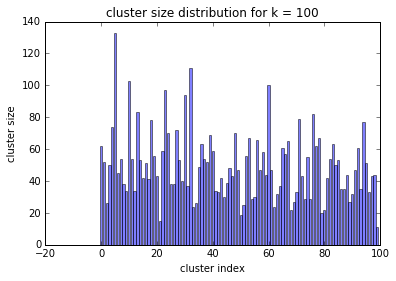

In [41]:
l = []
k = []
for i in kcluster.keys():
    l.append(len(kcluster[i]))
    k.append(list(kcluster.keys())[i])
plt.bar(k,l,align='center', alpha=0.5)
plt.xlabel('cluster index')
plt.ylabel('cluster size')
plt.title('cluster size distribution for k = 100')
 
plt.show()

### Generate sub-matrix & Save data

In [123]:
matrix = []
for i in range(100):
    a = df_description.ix[kcluster[i]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
    pivot = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value = 0).transpose()
    matrix.append(pivot)
matrix[1].head(10)

reviewer,A09768021CXERSKV95X9D,A105P7FB419RWG,A106C41CBPJTUF,A10EPCBWOVQMRS,A10FBCA2RGV549,A10GBVGIHKHYDC,A1178A4MRRKU71,A117SBSBK8BESS,A12LLNAGWUE7S6,A12OUSOIMBOO3I,...,AW2G7S5PJ8ZA1,AX550SW9WK9DO,AXNPDAYS5E646,AXSUSU4TMZGVJ,AXU8JPYYVGE69,AXW68BF33KL2R,AXWQU2W6EDIC3,AY9GRN5MO8HC1,AYBSZT99C59U4,AZ425ZQZNKYP2
asin,,,,,,,,,,,,,,,,,,,,,
B004UWB3UU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B005SE8IFW,0,5,0,0,5,0,0,0,0,0,...,0,5,4,0,5,0,5,0,0,0
B005VEJUEW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B006BEBADU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0070Z89KG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B007S19QF4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
B0089MWGSA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B008CGH1DI,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B008HU5SQ6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4,0,0


In [60]:
rating_pair = []
for i in range(100):
    a = df_description.ix[kcluster[i]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
    pivot = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating').transpose()
    s = pivot.mean()
    pairs = list(zip(s.index, s))
    for j in range(len(pairs)):
        pairs[j] += ('cluster' + str(i),)
    rating_pair += pairs

In [125]:
df_101 = pd.DataFrame(rating_pair, columns=['reviewer', 'rating', 'cluster'])
df_101_pivot = pd.pivot_table(df_101, index='reviewer', columns='cluster', values='rating', fill_value = 0).transpose()
df_101_pivot.head()

reviewer,A00039763E5V43M02Z3YZ,A00111163LLS4KLYZXNZL,A002359833QJM7OQHCXWY,A00236702NOP1FKXVRFN3,A0026556YRYONJ90H57Z,A00281722IA12Z7XNGMJV,A0037670NPLI11RBWYFA,A0038872349TB5N0JHQQW,A004257029HNEB0RA4Z6V,A00440181FM3TJMYVT608,...,AZZIR7GU8SMIR,AZZJ1H7DM2UQD,AZZJG13YQANEA,AZZN34VU2X737,AZZN3MTTZHA74,AZZNEMLU7N9ET,AZZNWOFUDH8S2,AZZPCFDGCFI0D,AZZQ97SNW14J1,AZZYKX2KZ0Q82
cluster,,,,,,,,,,,,,,,,,,,,,
cluster0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cluster1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cluster10,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cluster11,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
cluster12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
import pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(kcluster, handle, protocol=2)

In [45]:
data[['asin', 'reviewer', 'star_rating']].to_csv('no_outlier_data.csv')

In [47]:
df_description.to_csv('description.csv')